In [5]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

large_images = True

%matplotlib inline
if large_images:
    import matplotlib as mlp
    mlp.rcParams['figure.dpi'] = 300

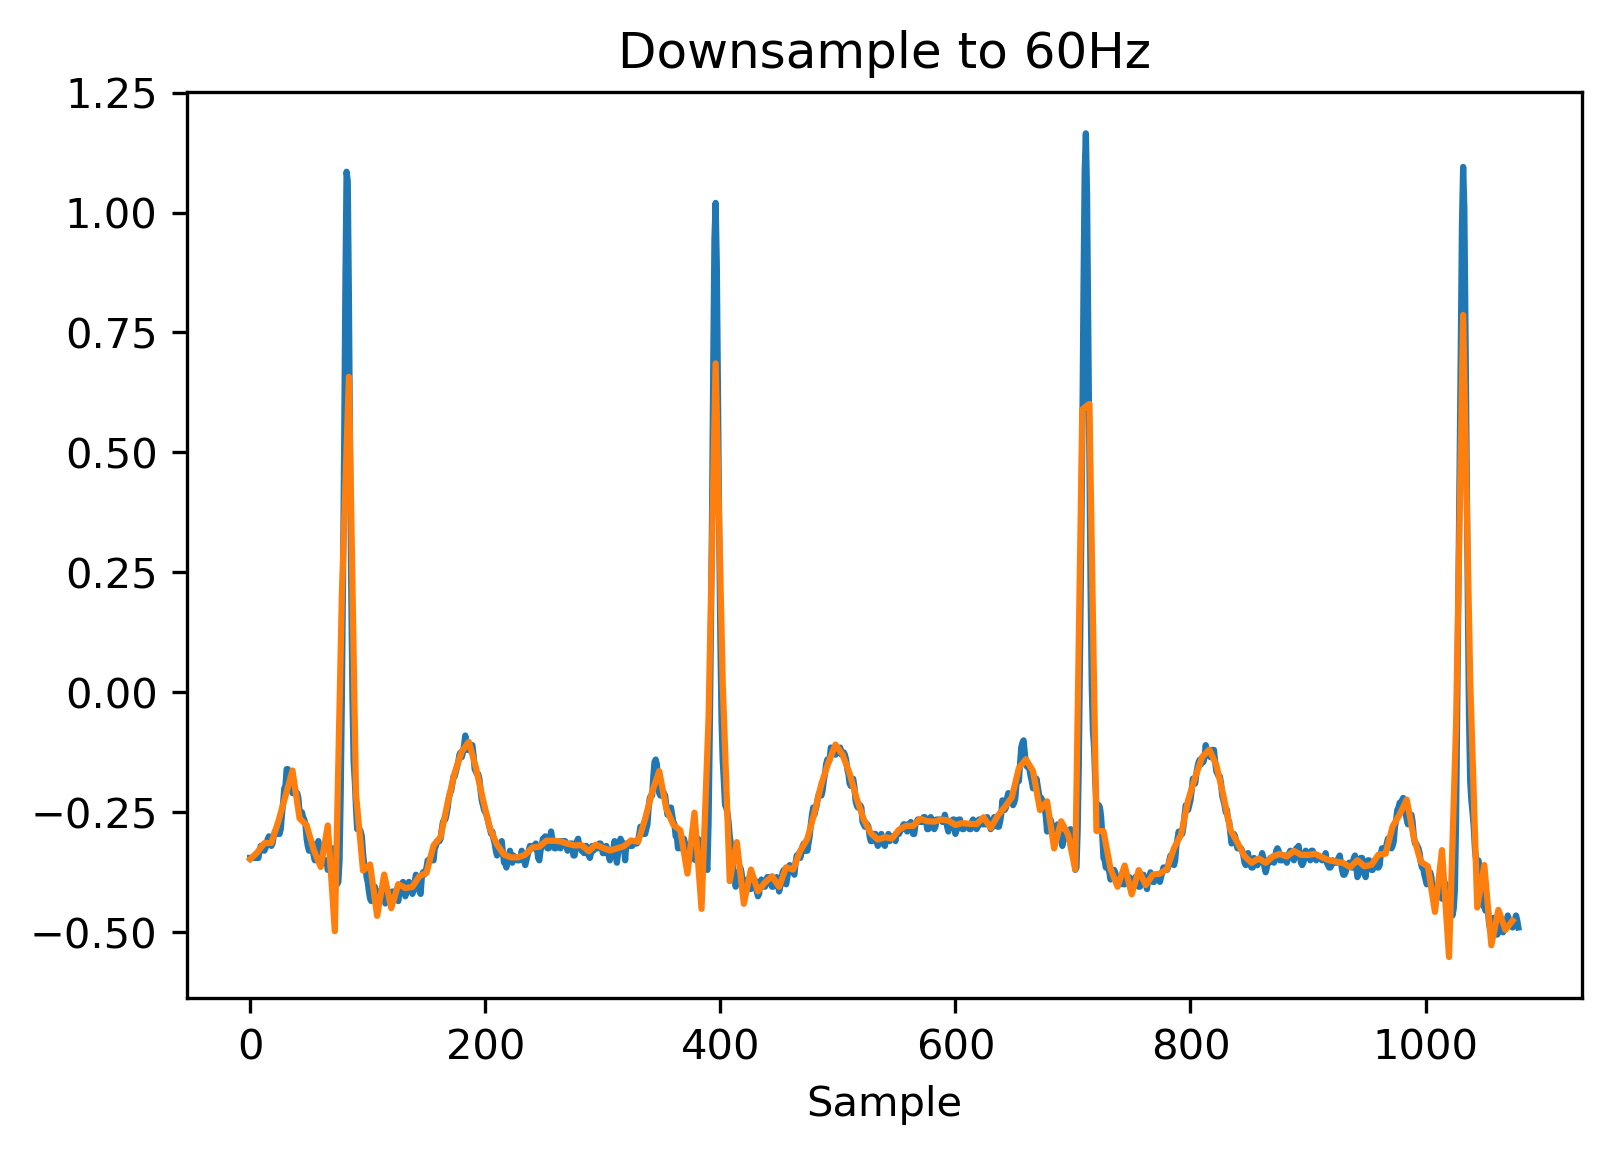

Unique label sets and their count:
[0. 0. 0.] 982
[0. 1. 0.] 634
[0. 1. 1.] 129
[1. 0. 0.] 321
[1. 0. 1.] 4
[1. 1. 0.] 180
[1. 1. 1.] 82
Total of 2332 samples


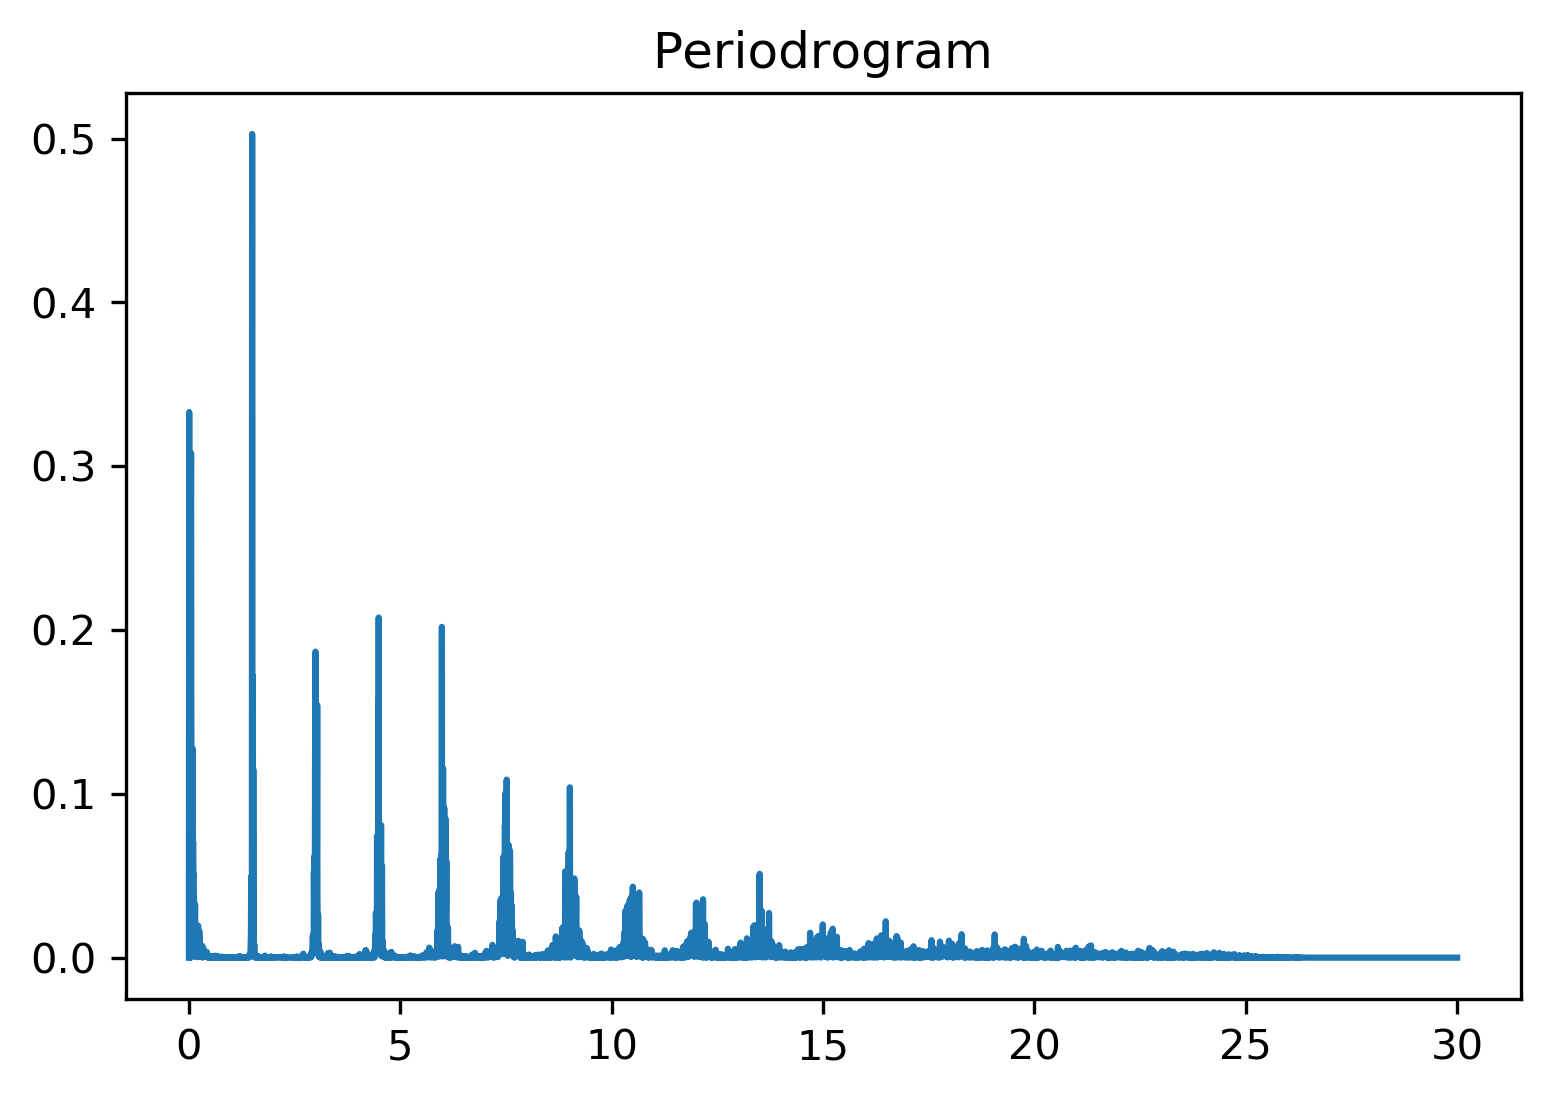

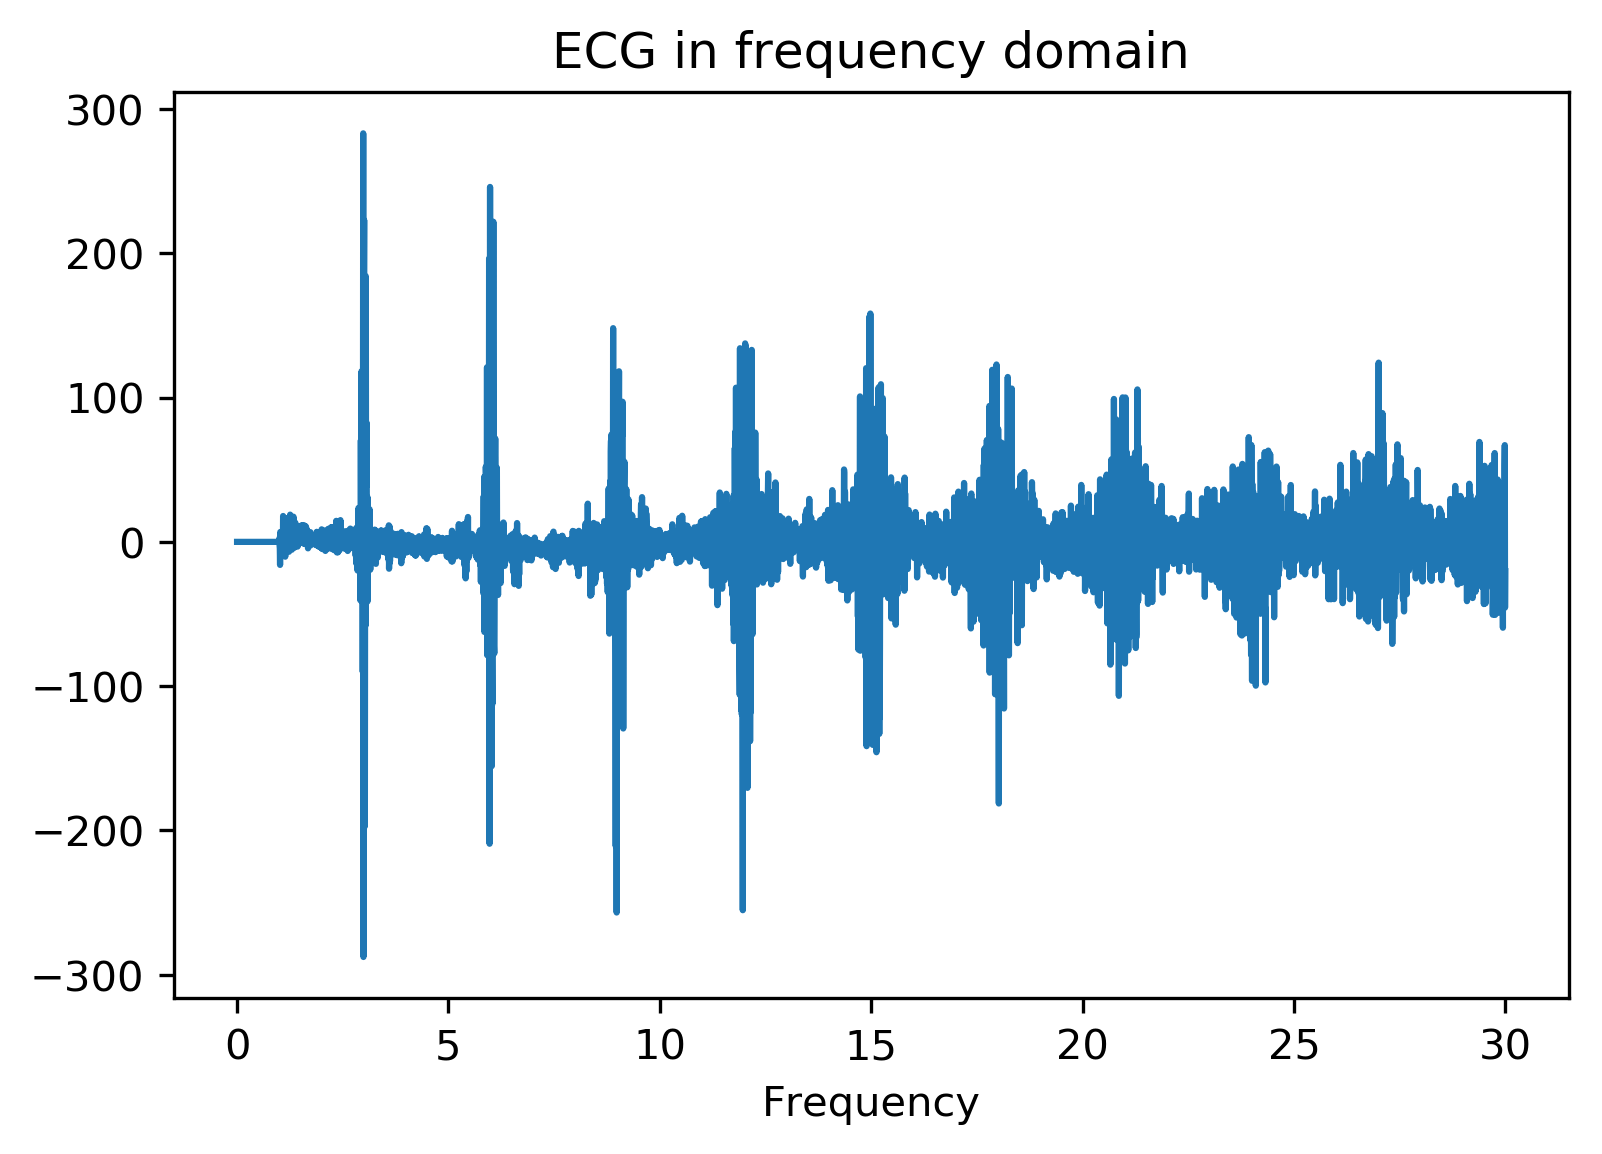

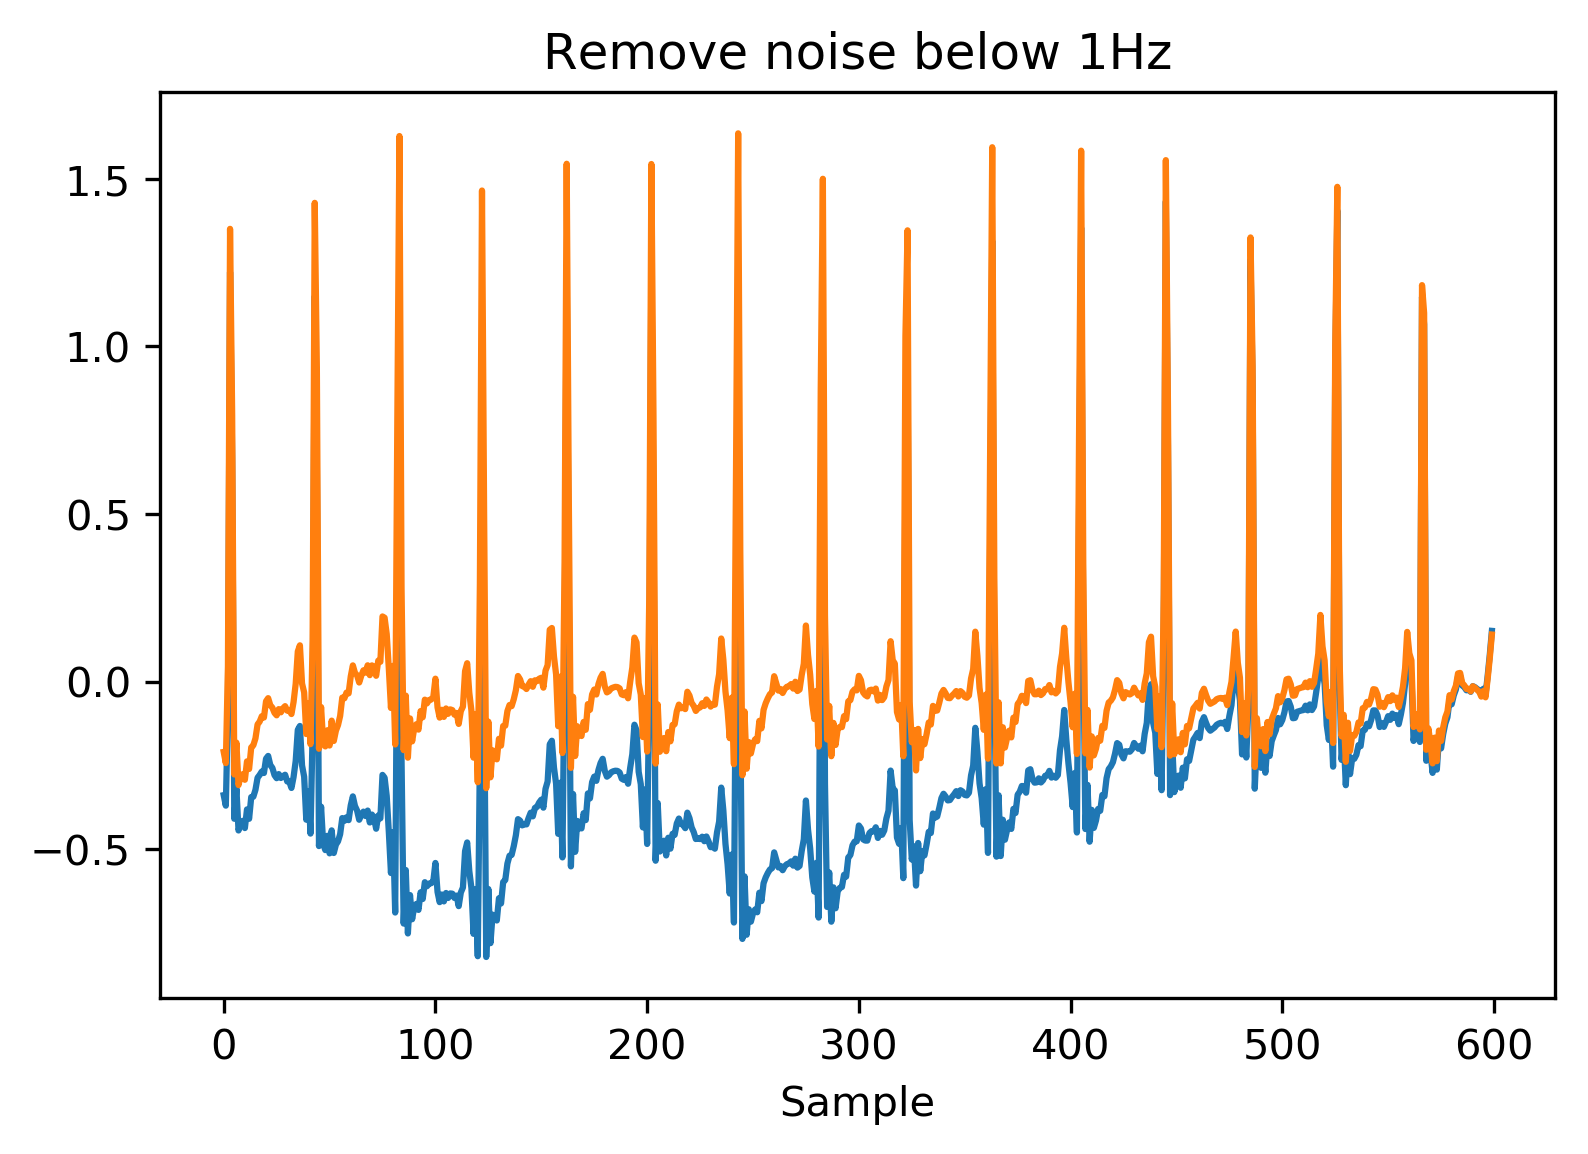

In [6]:
# Load all mitdb records
full_data = mitdb.get_records(mitdb.full_ds)

# Slice all data into time frames of size 10 min + 5 min
from arrhythmia.experimental.common import slice_records
from arrhythmia.model.helpers import beat_types
from arrhythmia.model.preprocessing import downsample

pred_minutes = 3
post_minutes = 1

pred_window = 360 * 60 * pred_minutes
post_window = 360 * 60 * post_minutes

slicer = slice_records(full_data, pred_window, post_window, increment=360 * 30, check_pred=False)

# Convert loaded data into model input and expected classes
def to_classes(labels, threshold=1):
    targets = np.zeros(len(beat_types[1:-1]), dtype=np.float32)
    for i, bt in enumerate(beat_types[1:-1]):
        count = np.sum(labels == bt.symbol)
        targets[i] = 1.0 if count >= threshold else 0.0
    return targets

# Downsample data to reduce number of features and remove high f. noise at the same time
frequency = 360
target_frequency = 60
input_data = []
classes = []
for i, (pred, post) in enumerate(slicer):
    data = pred[0]
    cl = to_classes(post[2])
    if target_frequency != frequency:
        if i == 0:
            plt.plot(data[:frequency*3])
        data = downsample(data, frequency // target_frequency)
        if i == 0:
            back_x = np.arange(0, frequency*3, frequency // target_frequency)
            plt.plot(back_x, data[:target_frequency*3])
            plt.title('Downsample to {}Hz'.format(target_frequency))
            plt.xlabel('Sample')
            plt.show()

    input_data.append(data)
    classes.append(cl)

frequency = target_frequency
        
input_data = np.array(input_data)
classes = np.array(classes)
        
unique, cnts = np.unique(classes, axis=0, return_counts=True)
print('Unique label sets and their count:')
for u, c in zip(unique, cnts):
    print(u, c)
print('Total of {} samples'.format(sum(cnts)))

# Plot periodogram
periodogram = True
if periodogram:
    from scipy.signal import periodogram
    f, pxx = periodogram(input_data[-2], frequency, return_onesided=True)
    plt.plot(f, pxx)
    plt.title('Periodrogram')
    plt.show()

# Remove low frequency noise using FFT->IFFT
fft = True
replace_with_fft = False
fft_threshold = 1
if fft:
    from scipy import fftpack
    after_fft = fftpack.rfft(input_data)

    fft_freq = fftpack.fftfreq(after_fft.shape[-1], d=1/frequency)

    after_fft[:, np.abs(fft_freq) < fft_threshold] = 0
    halfsize = after_fft.shape[1]//2
    plt.plot(fft_freq[:halfsize], after_fft[-2, :halfsize].real)
    plt.title('ECG in frequency domain')
    plt.xlabel('Frequency')
    plt.show()
    
    if not replace_with_fft:
        plt.plot(input_data[-2][:frequency*10])
        input_data = fftpack.irfft(after_fft)
        plt.plot(input_data[-2][:frequency*10])
        plt.title('Remove noise below {}Hz'.format(fft_threshold))
        plt.xlabel('Sample')
        plt.show()
    else:
        input_data = fft_freq.real

input_data = np.array(input_data)
input_shape = input_data.shape[1:]

# Normalize input data
from arrhythmia.experimental.common import normalize_mean_std

input_data_n = normalize_mean_std(input_data)

In [7]:
from arrhythmia.experimental.common import ModelTester
import keras.backend as K
# TODO Update keras to use those metrics
#from keras.metrics import precision, recall

tester = ModelTester(input_data_n, classes, verbose=0)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

metrics = ['binary_accuracy', 'mse', precision, recall, fmeasure]

window_postfix = str(pred_minutes) + '_' + str(post_minutes)
def network_name(name):
    return 'mlp_{}_f{}_fft_win_{}_{}.hdf5'.format(name, frequency, pred_minutes, post_minutes)

## Networks:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten


def dense_network(layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = inputs
        for layer in layers:
            x = Dense(layer, activation='relu')(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

def conv_network(pool=4, layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = Reshape((*input_shape, 1))(inputs)
        for size, num in layers:
            x = Conv1D(size, num, activation='relu')(x)
            x = MaxPooling1D(pool_size=pool)(x)
        x = Flatten()(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

Testing dense model with layers: [10, 50, 10]
Trained for 12 epochs
loss: 0.5358, binary_accuracy: 0.7238, mean_squared_error: 0.1781, precision: 0.4172, recall: 0.1737, fmeasure: 0.2293
Trained for 12 epochs
loss: 0.5214, binary_accuracy: 0.7459, mean_squared_error: 0.1716, precision: 0.4311, recall: 0.2015, fmeasure: 0.2716
Trained for 16 epochs
loss: 0.5332, binary_accuracy: 0.7546, mean_squared_error: 0.1747, precision: 0.5420, recall: 0.1539, fmeasure: 0.2354
Trained for 11 epochs
loss: 0.5540, binary_accuracy: 0.7246, mean_squared_error: 0.1799, precision: 0.3830, recall: 0.1643, fmeasure: 0.2129
Trained for 15 epochs
loss: 0.5660, binary_accuracy: 0.7003, mean_squared_error: 0.1920, precision: 0.4453, recall: 0.3003, fmeasure: 0.3159
loss: 0.5421 (+/-0.0159), binary_accuracy: 0.7298 (+/-0.0190), mean_squared_error: 0.1793 (+/-0.0070), precision: 0.4437 (+/-0.0533), recall: 0.1988 (+/-0.0532), fmeasure: 0.2530 (+/-0.0368)


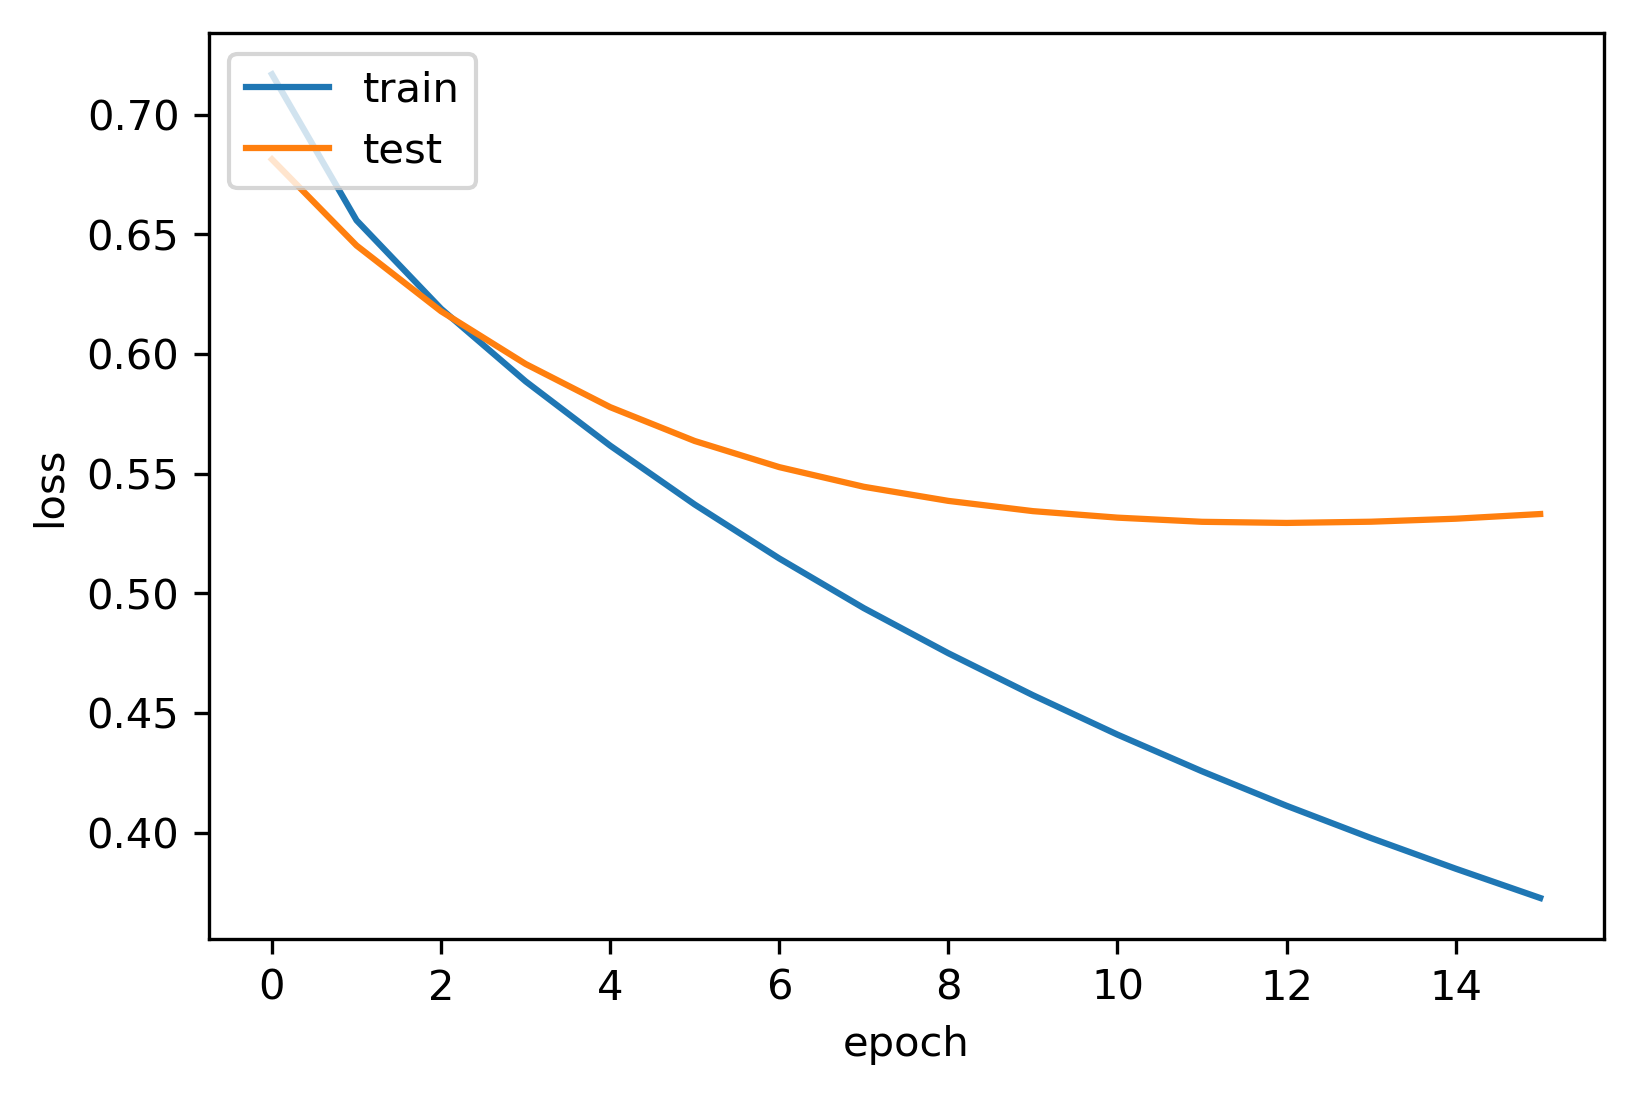

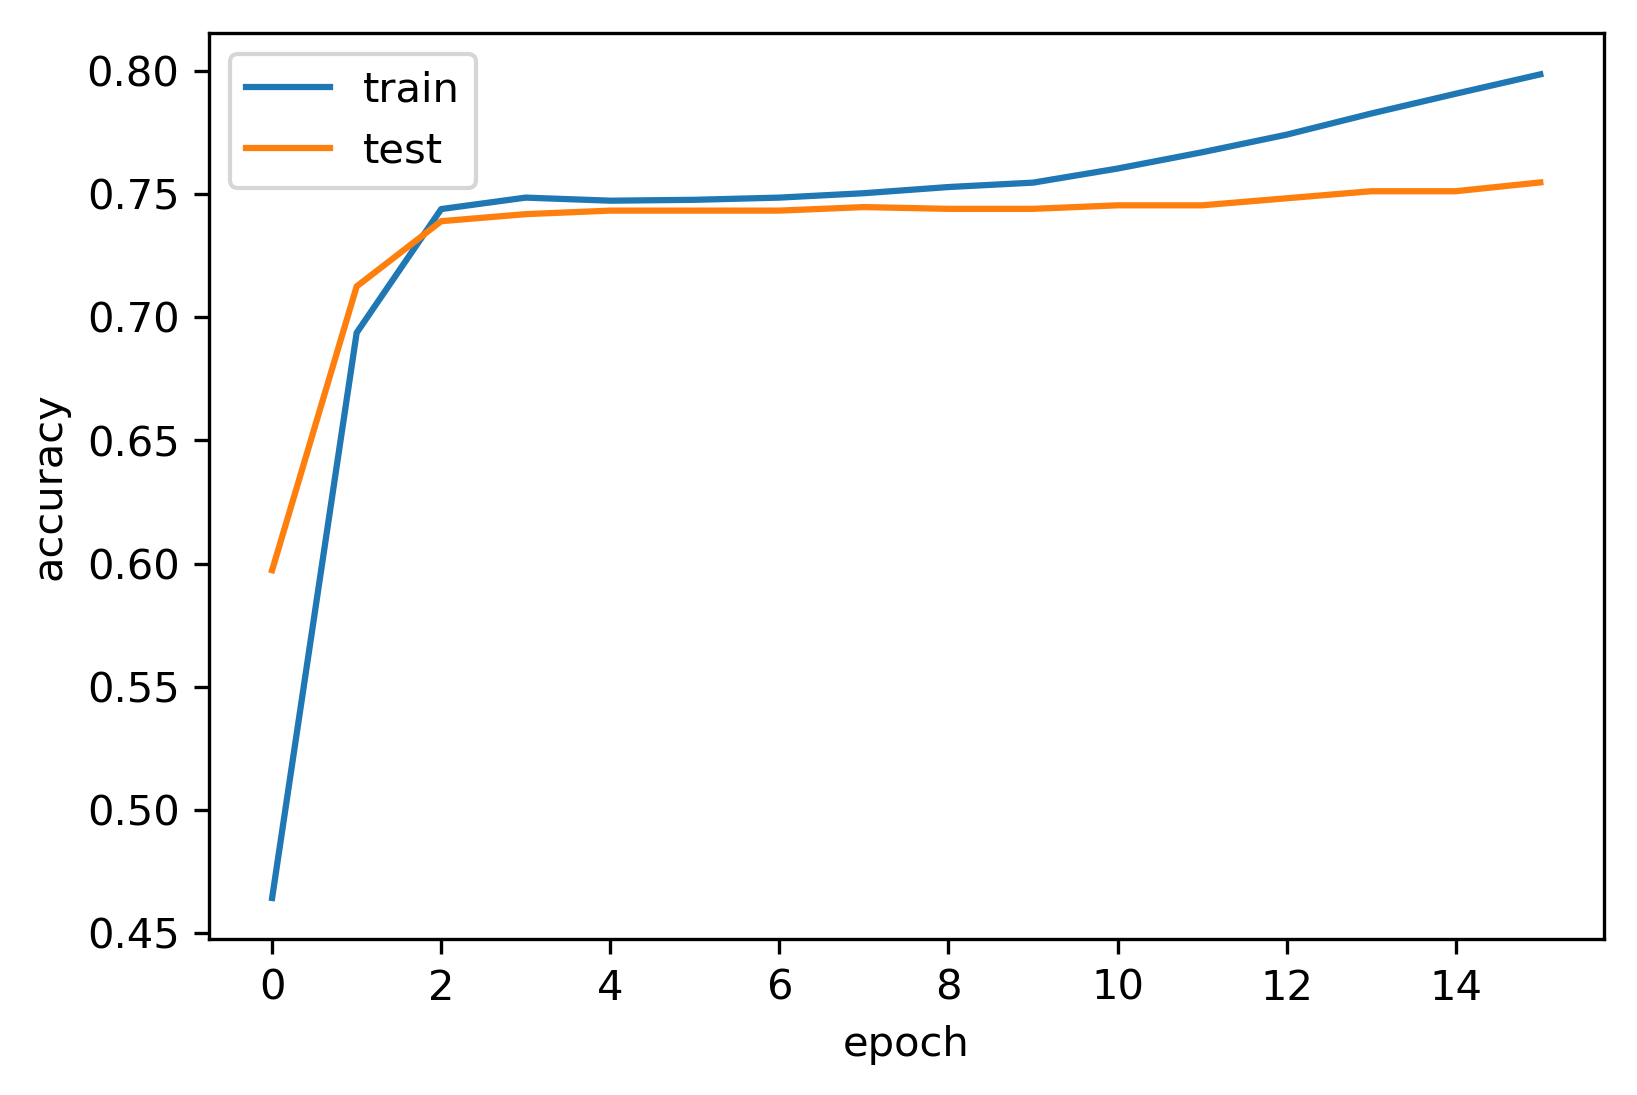

Testing dense model with layers: [100, 100]
Trained for 7 epochs
loss: 0.5474, binary_accuracy: 0.7466, mean_squared_error: 0.1808, precision: 0.5032, recall: 0.2808, fmeasure: 0.3290
Trained for 9 epochs
loss: 0.5211, binary_accuracy: 0.7530, mean_squared_error: 0.1721, precision: 0.4584, recall: 0.2794, fmeasure: 0.3371
Trained for 7 epochs
loss: 0.5547, binary_accuracy: 0.7389, mean_squared_error: 0.1817, precision: 0.4327, recall: 0.2634, fmeasure: 0.3143
Trained for 7 epochs
loss: 0.5503, binary_accuracy: 0.7361, mean_squared_error: 0.1831, precision: 0.4239, recall: 0.2682, fmeasure: 0.3175
Trained for 7 epochs
loss: 0.5623, binary_accuracy: 0.7196, mean_squared_error: 0.1877, precision: 0.4571, recall: 0.2094, fmeasure: 0.2643
loss: 0.5471 (+/-0.0140), binary_accuracy: 0.7388 (+/-0.0113), mean_squared_error: 0.1811 (+/-0.0051), precision: 0.4551 (+/-0.0276), recall: 0.2603 (+/-0.0263), fmeasure: 0.3124 (+/-0.0254)


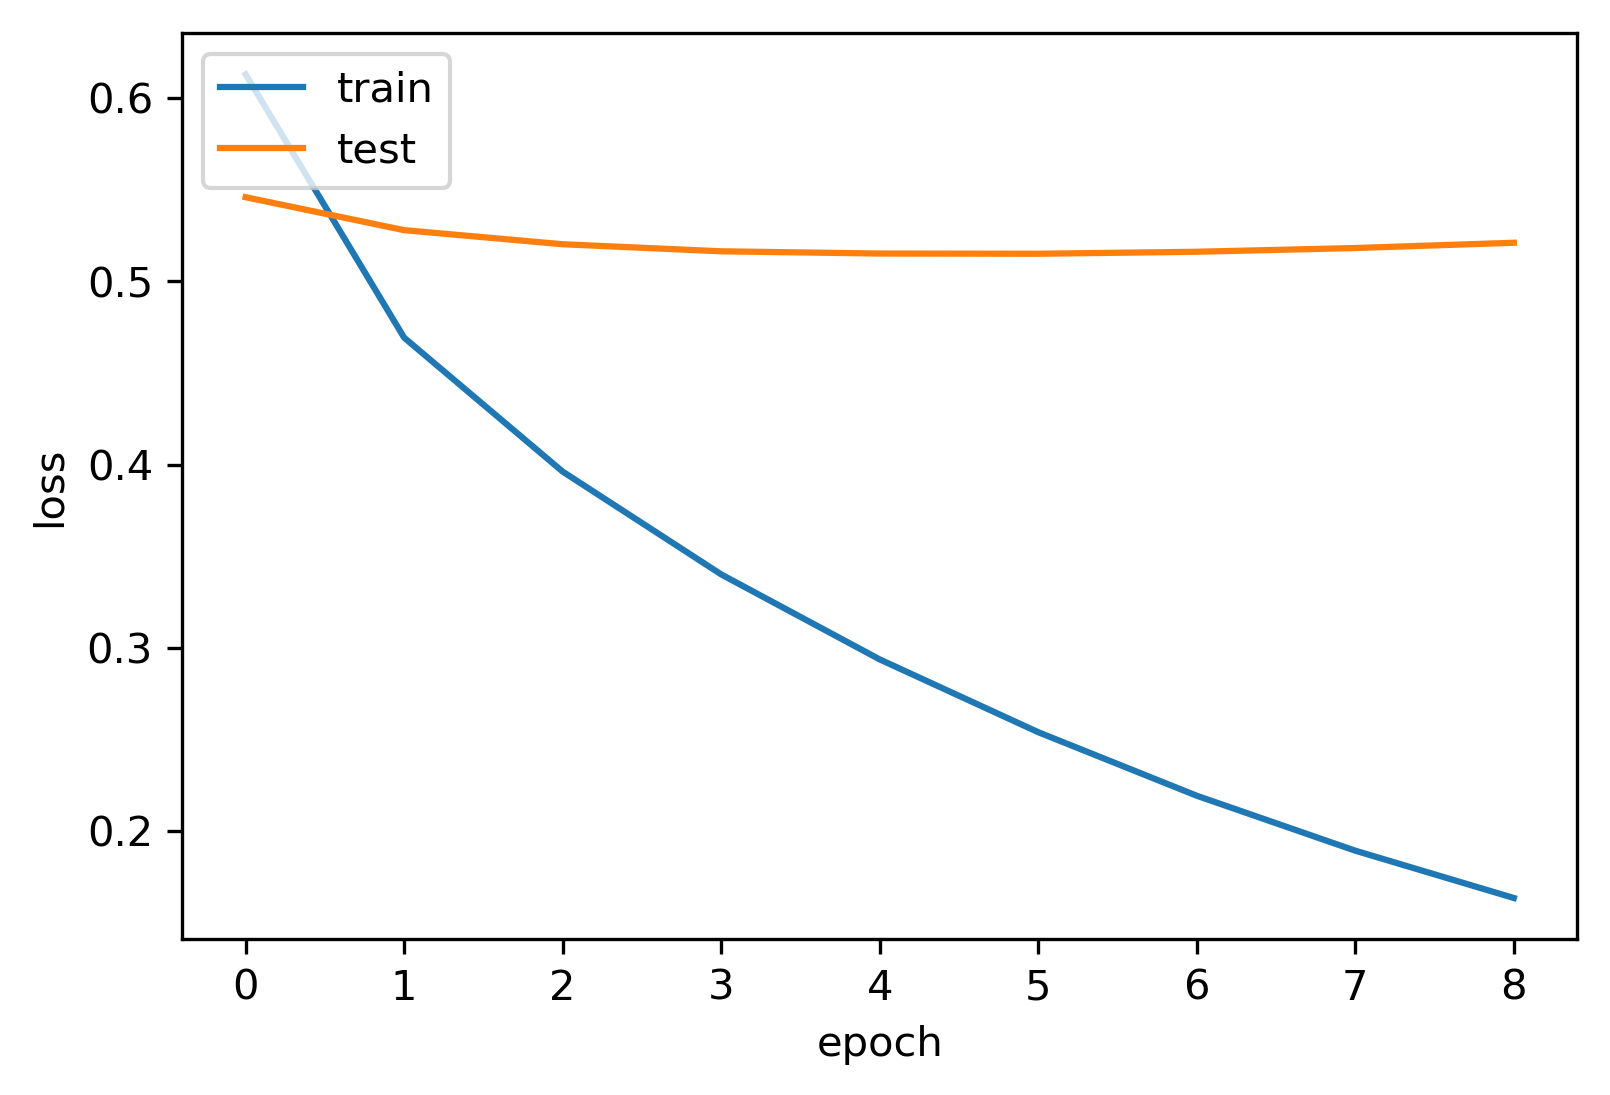

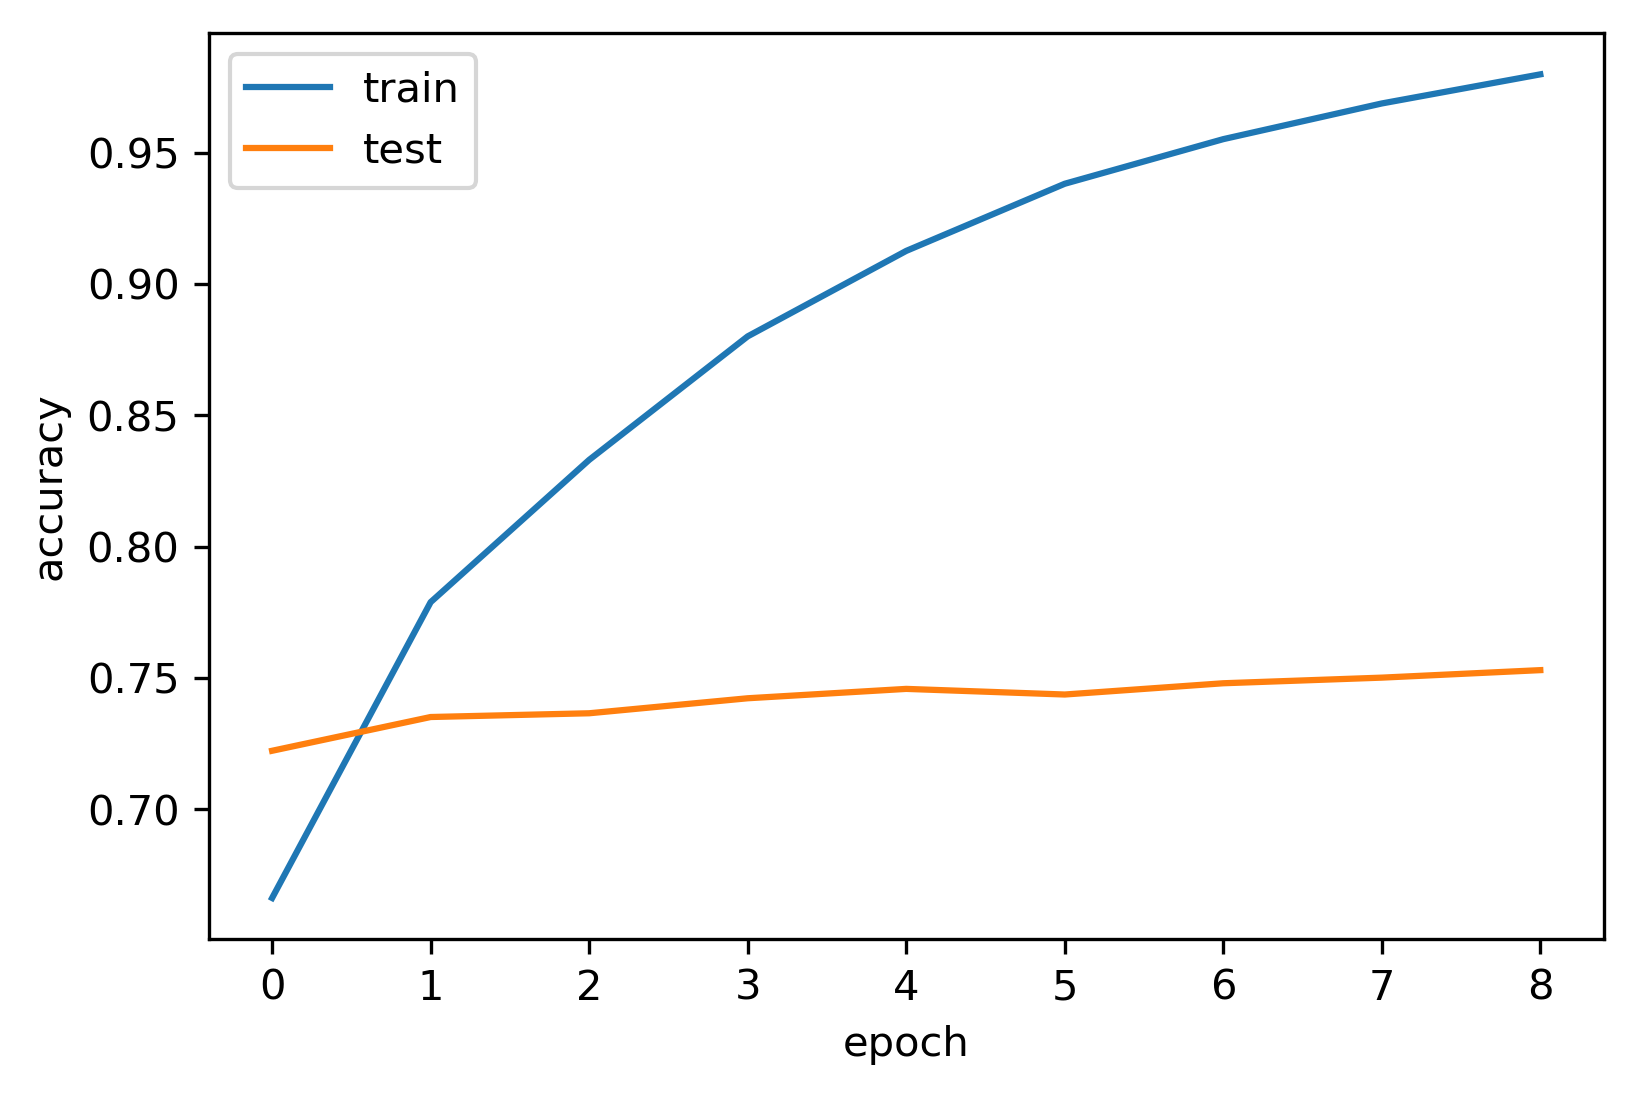

Testing dense model with layers: [100, 200, 100]
Trained for 9 epochs
loss: 0.5204, binary_accuracy: 0.7395, mean_squared_error: 0.1740, precision: 0.4619, recall: 0.2152, fmeasure: 0.2809
Trained for 9 epochs
loss: 0.5040, binary_accuracy: 0.7480, mean_squared_error: 0.1660, precision: 0.4340, recall: 0.2807, fmeasure: 0.3328
Trained for 7 epochs
loss: 0.5301, binary_accuracy: 0.7389, mean_squared_error: 0.1760, precision: 0.3969, recall: 0.1784, fmeasure: 0.2300
Trained for 8 epochs
loss: 0.5222, binary_accuracy: 0.7318, mean_squared_error: 0.1746, precision: 0.4375, recall: 0.1994, fmeasure: 0.2664
Trained for 7 epochs
loss: 0.5513, binary_accuracy: 0.7160, mean_squared_error: 0.1850, precision: 0.4025, recall: 0.1782, fmeasure: 0.2417
loss: 0.5256 (+/-0.0154), binary_accuracy: 0.7348 (+/-0.0107), mean_squared_error: 0.1751 (+/-0.0060), precision: 0.4266 (+/-0.0240), recall: 0.2104 (+/-0.0378), fmeasure: 0.2704 (+/-0.0360)


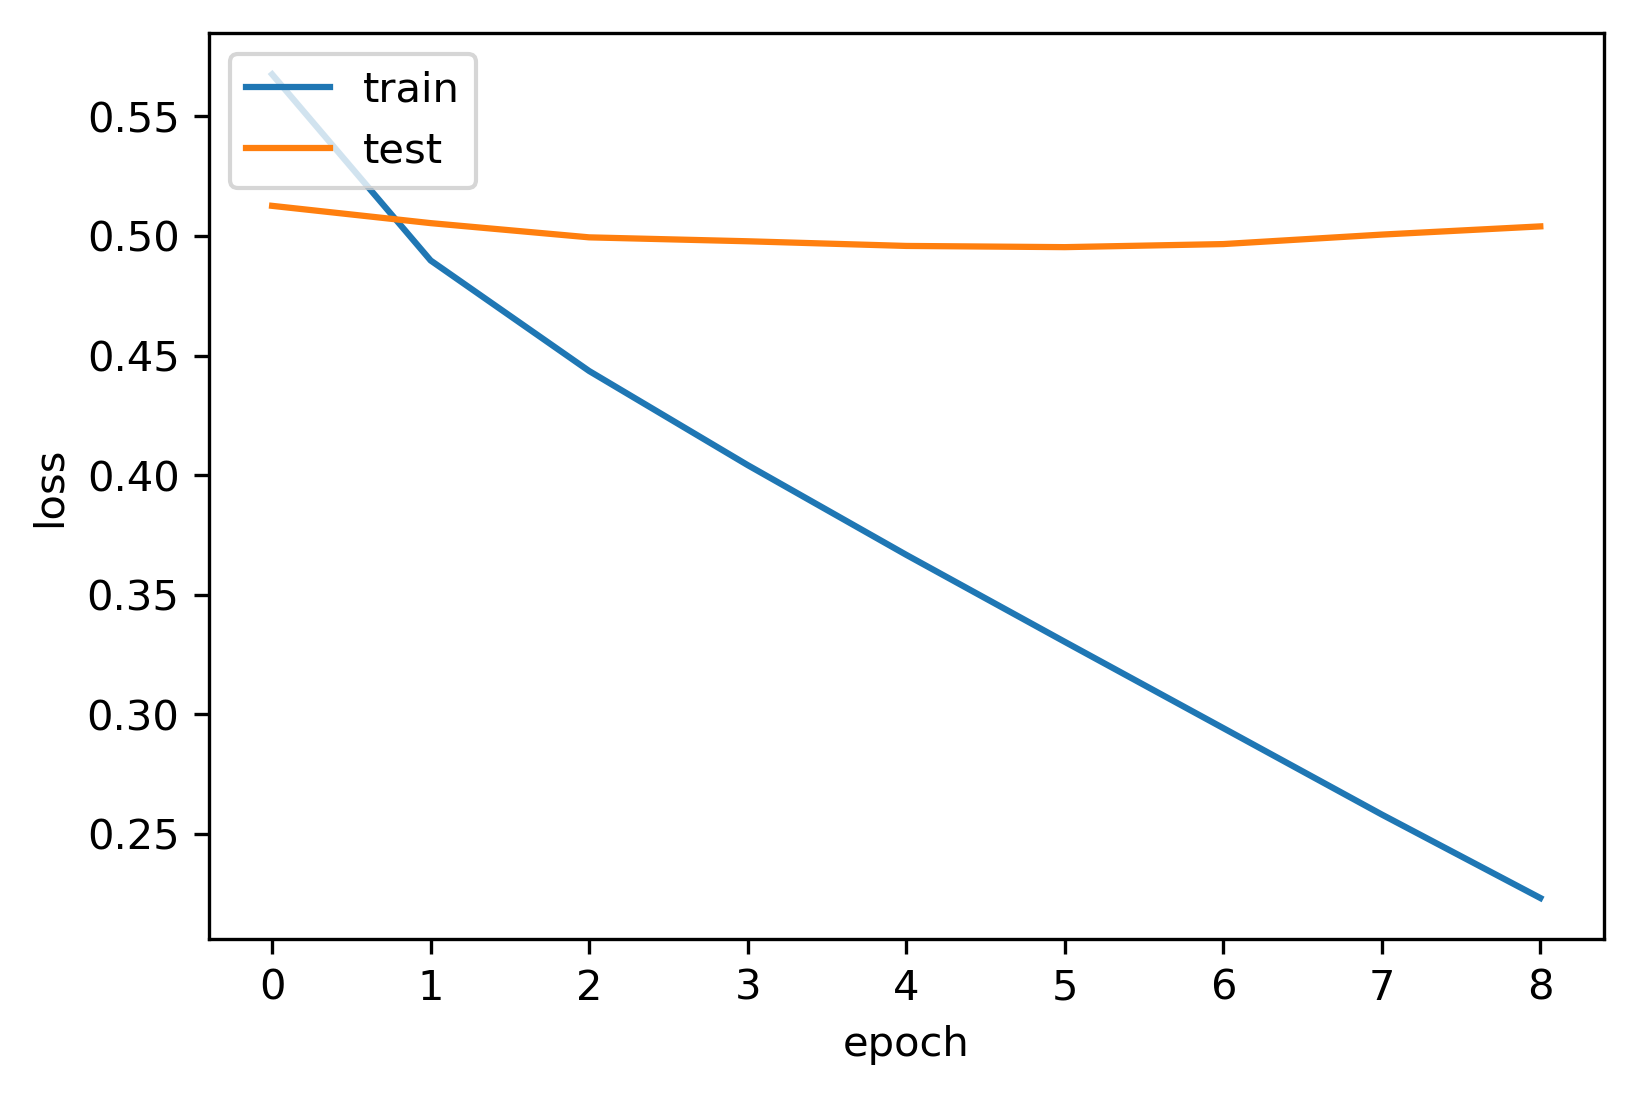

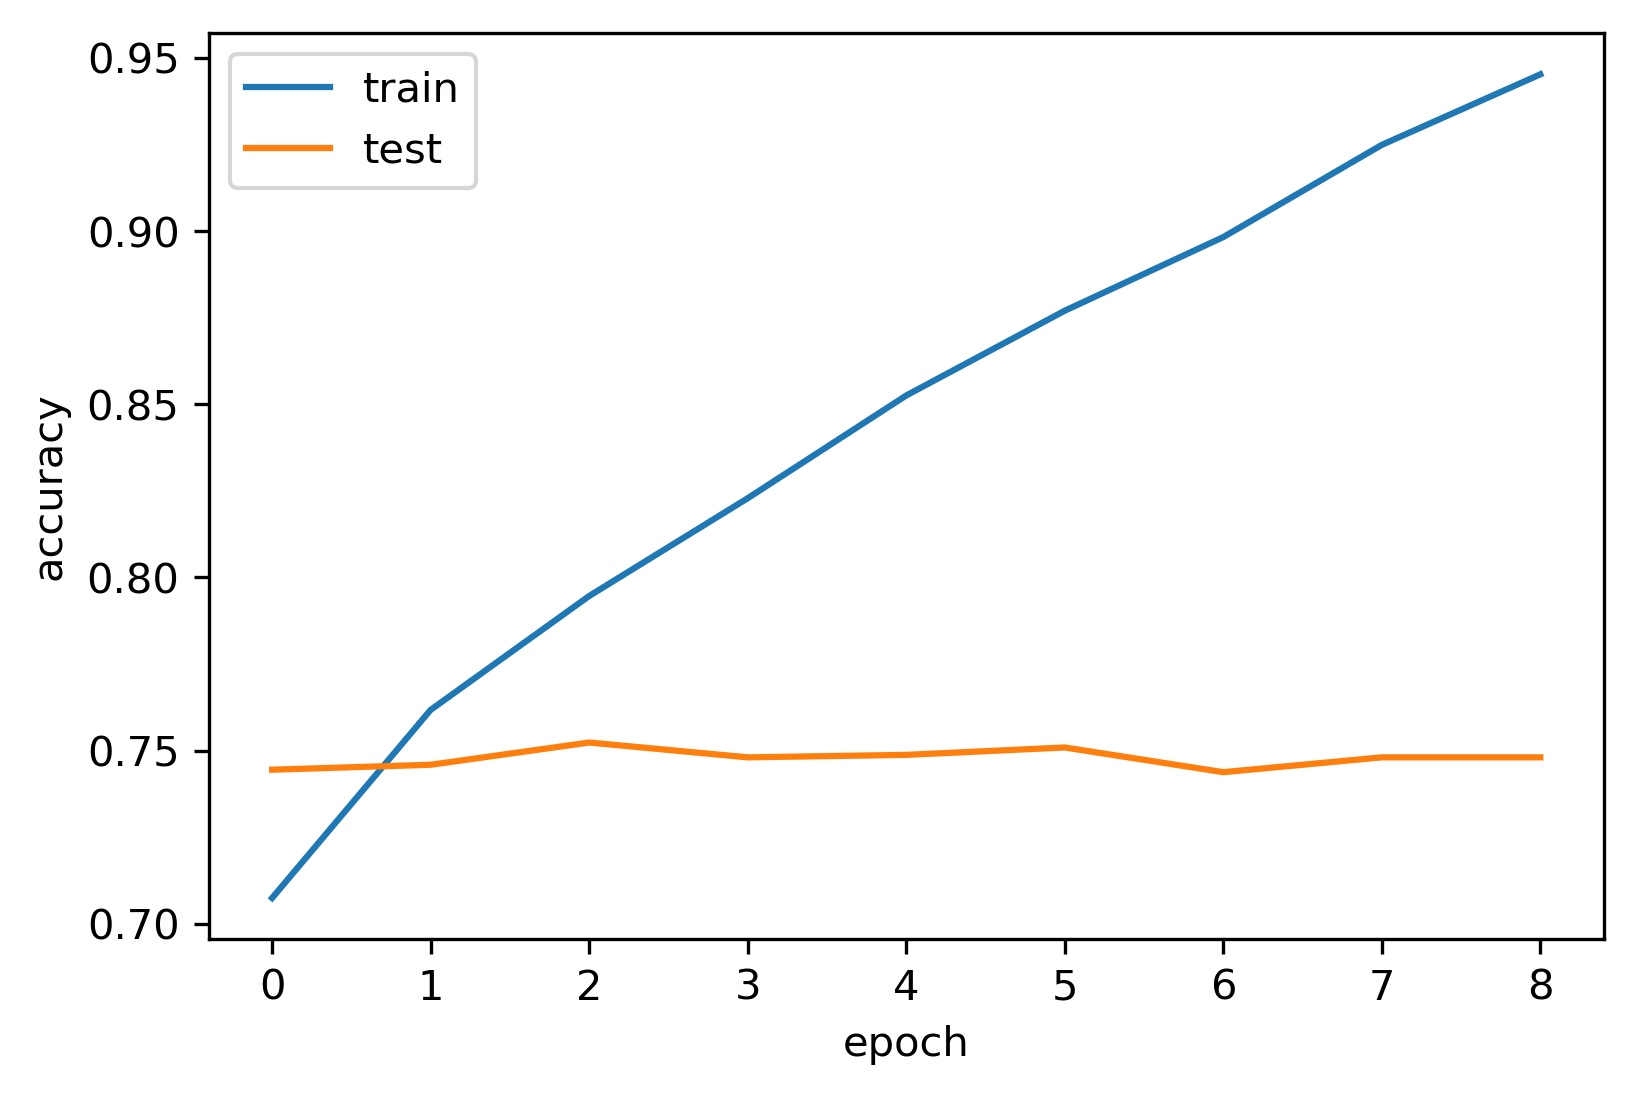

In [8]:
import itertools

considered_widths = [
    [10, 50, 10],
    [100, 100],
    [100, 200, 100]
]

for widths in considered_widths:
    print('Testing dense model with layers: {}'.format(widths))
    filename = network_name('dense_' + '_'.join([str(w) for w in widths]))
    simple_trained = tester.test_model(dense_network(widths), max_epochs=50)
    # Dense networks have very poor results and easily overfit - we disable saving them
    simple_trained.save(filename)

Test convolutional network with parameters {'pool': 16, 'layers': [(4, 16), (16, 16)]}:
Trained for 17 epochs
loss: 0.3890, binary_accuracy: 0.8237, mean_squared_error: 0.1241, precision: 0.8068, recall: 0.4420, fmeasure: 0.5406
Trained for 28 epochs
loss: 0.3226, binary_accuracy: 0.8680, mean_squared_error: 0.0993, precision: 0.7172, recall: 0.6287, fmeasure: 0.6608
Trained for 16 epochs
loss: 0.3824, binary_accuracy: 0.8162, mean_squared_error: 0.1238, precision: 0.5676, recall: 0.6569, fmeasure: 0.5941
Trained for 12 epochs
loss: 0.3972, binary_accuracy: 0.8276, mean_squared_error: 0.1265, precision: 0.7986, recall: 0.3571, fmeasure: 0.4798
Trained for 22 epochs
loss: 0.3735, binary_accuracy: 0.8448, mean_squared_error: 0.1136, precision: 0.7786, recall: 0.5227, fmeasure: 0.6122
loss: 0.3729 (+/-0.0264), binary_accuracy: 0.8360 (+/-0.0185), mean_squared_error: 0.1175 (+/-0.0101), precision: 0.7338 (+/-0.0888), recall: 0.5215 (+/-0.1124), fmeasure: 0.5775 (+/-0.0622)


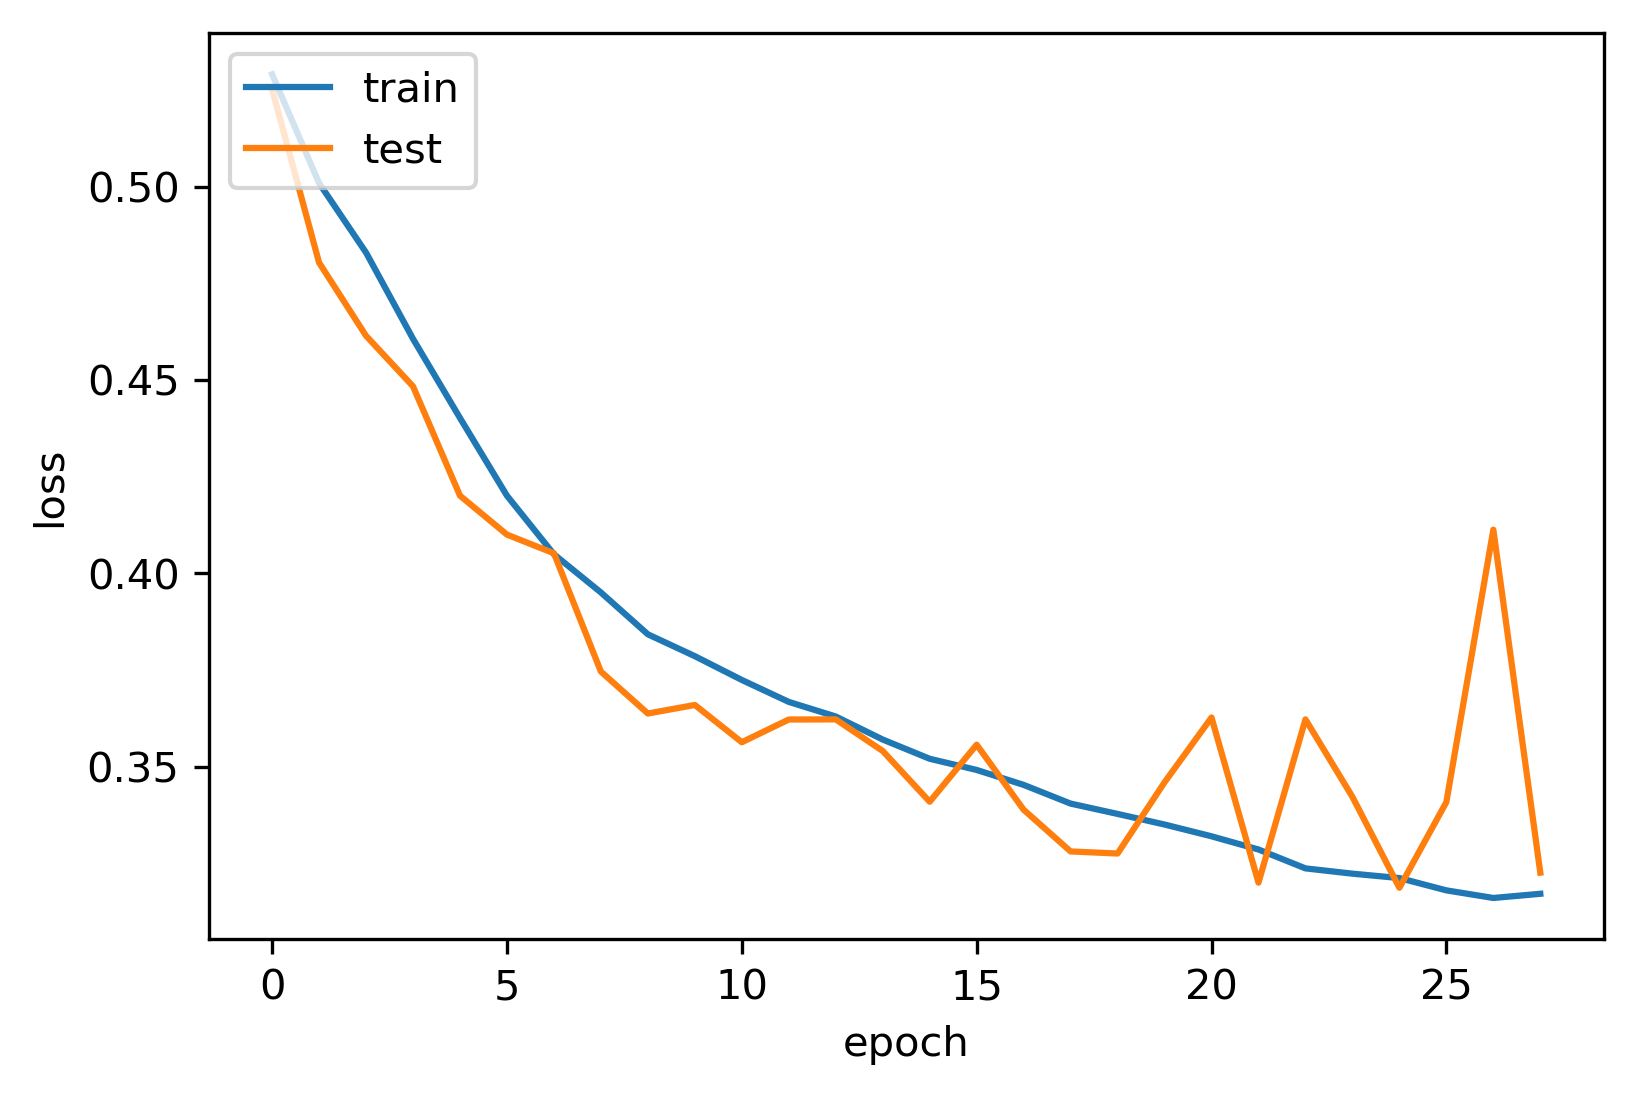

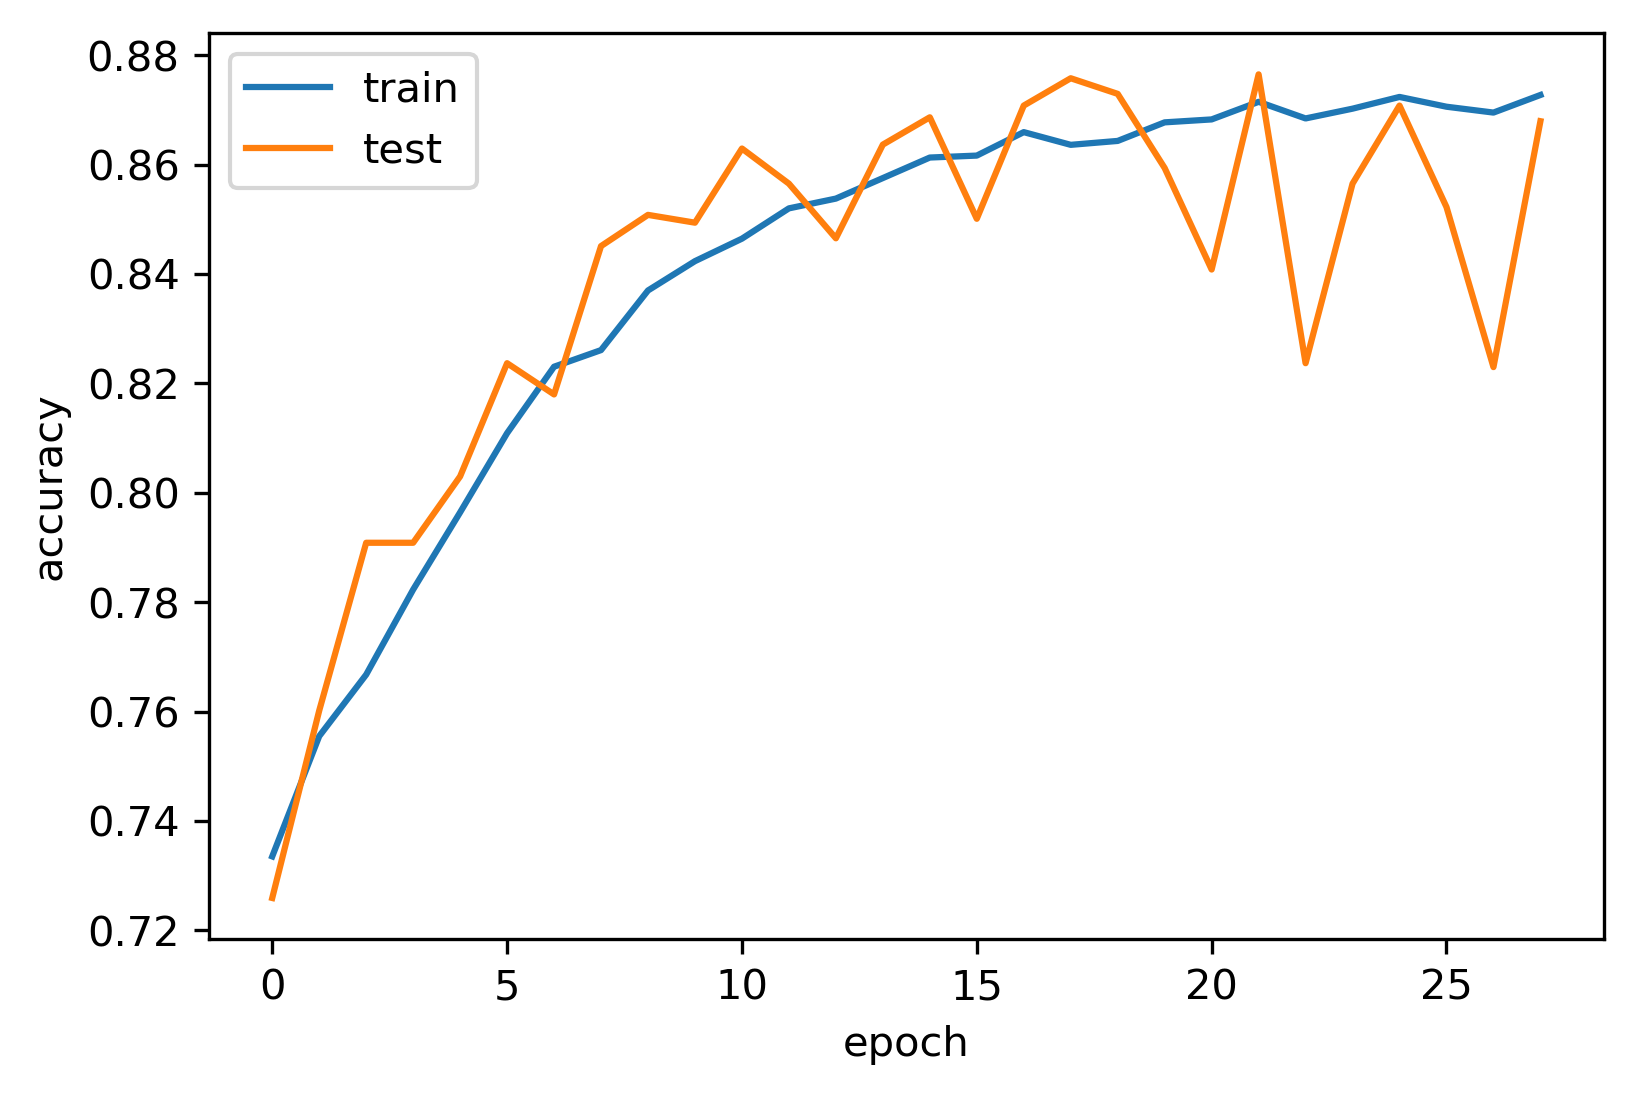

Test convolutional network with parameters {'pool': 16, 'layers': [(32, 16), (16, 16)]}:
Trained for 32 epochs
loss: 0.3008, binary_accuracy: 0.8787, mean_squared_error: 0.0918, precision: 0.8724, recall: 0.6175, fmeasure: 0.7072
Trained for 19 epochs
loss: 0.3086, binary_accuracy: 0.8822, mean_squared_error: 0.0932, precision: 0.7299, recall: 0.6631, fmeasure: 0.6868
Trained for 25 epochs
loss: 0.3230, binary_accuracy: 0.8763, mean_squared_error: 0.0983, precision: 0.8498, recall: 0.5180, fmeasure: 0.6310
Trained for 21 epochs
loss: 0.3780, binary_accuracy: 0.8441, mean_squared_error: 0.1170, precision: 0.6614, recall: 0.6351, fmeasure: 0.6286
Trained for 20 epochs
loss: 0.5238, binary_accuracy: 0.7718, mean_squared_error: 0.1631, precision: 0.5402, recall: 0.6828, fmeasure: 0.5751
loss: 0.3669 (+/-0.0830), binary_accuracy: 0.8506 (+/-0.0417), mean_squared_error: 0.1127 (+/-0.0268), precision: 0.7307 (+/-0.1228), recall: 0.6233 (+/-0.0572), fmeasure: 0.6457 (+/-0.0468)


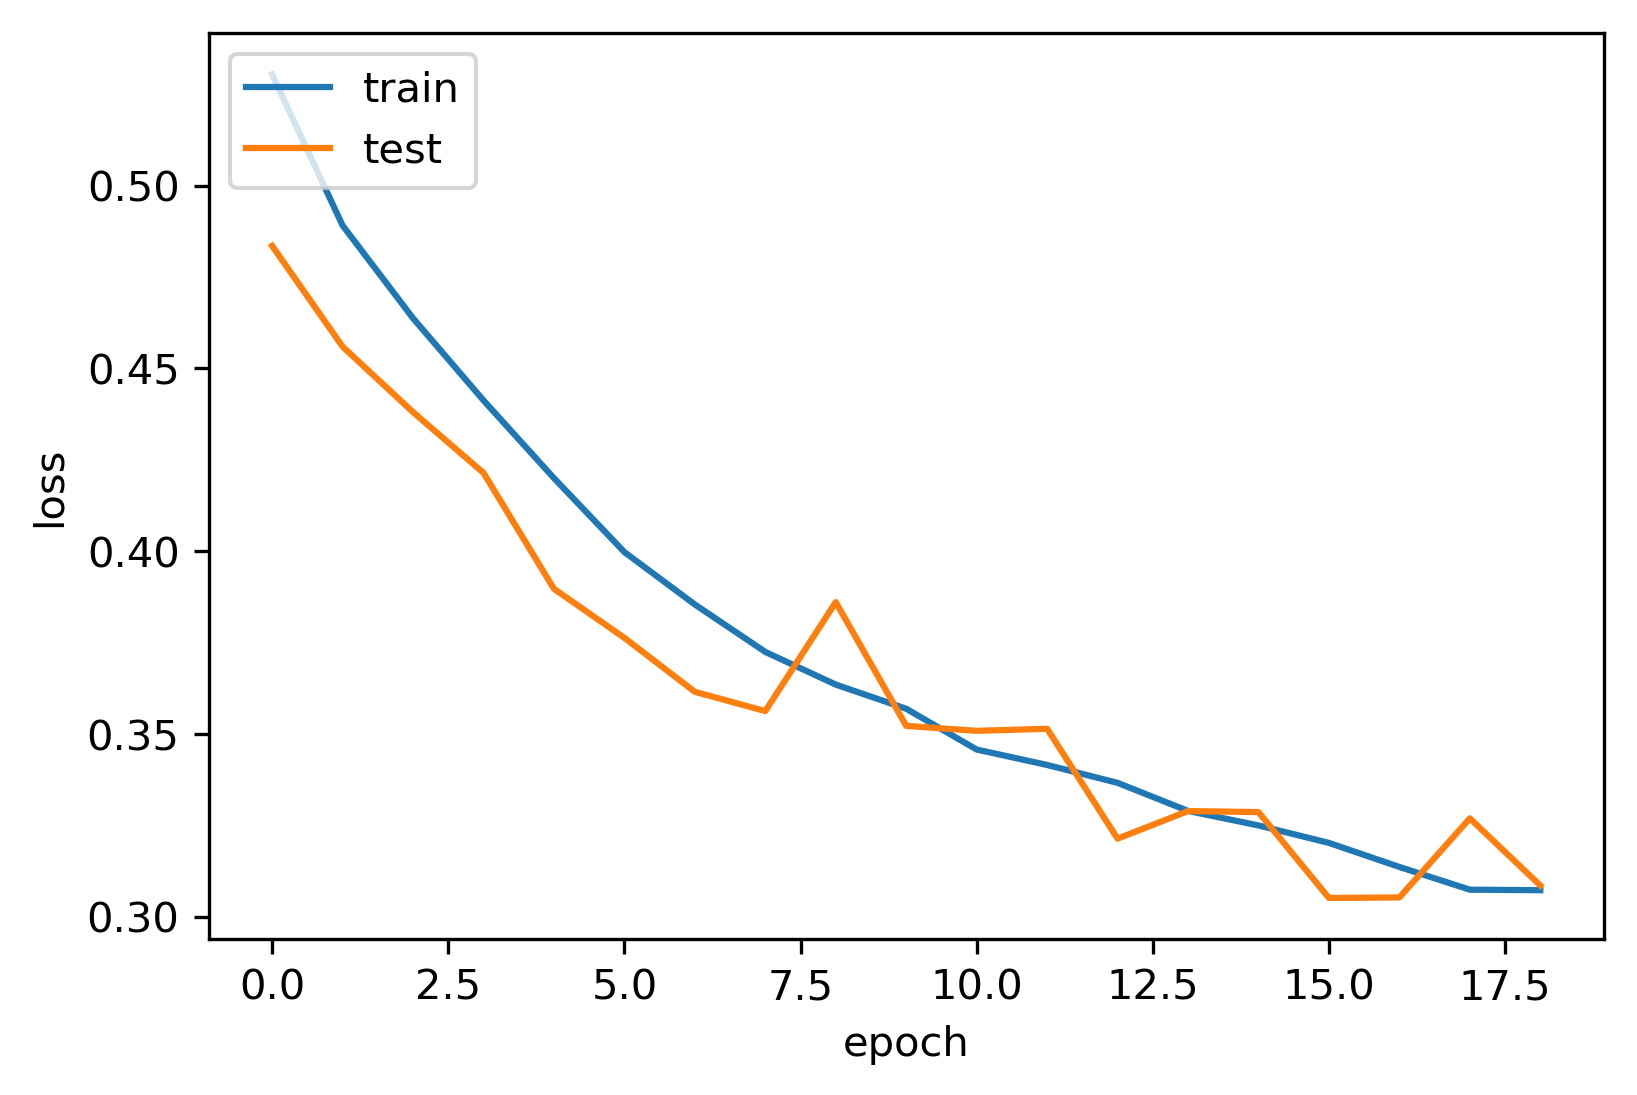

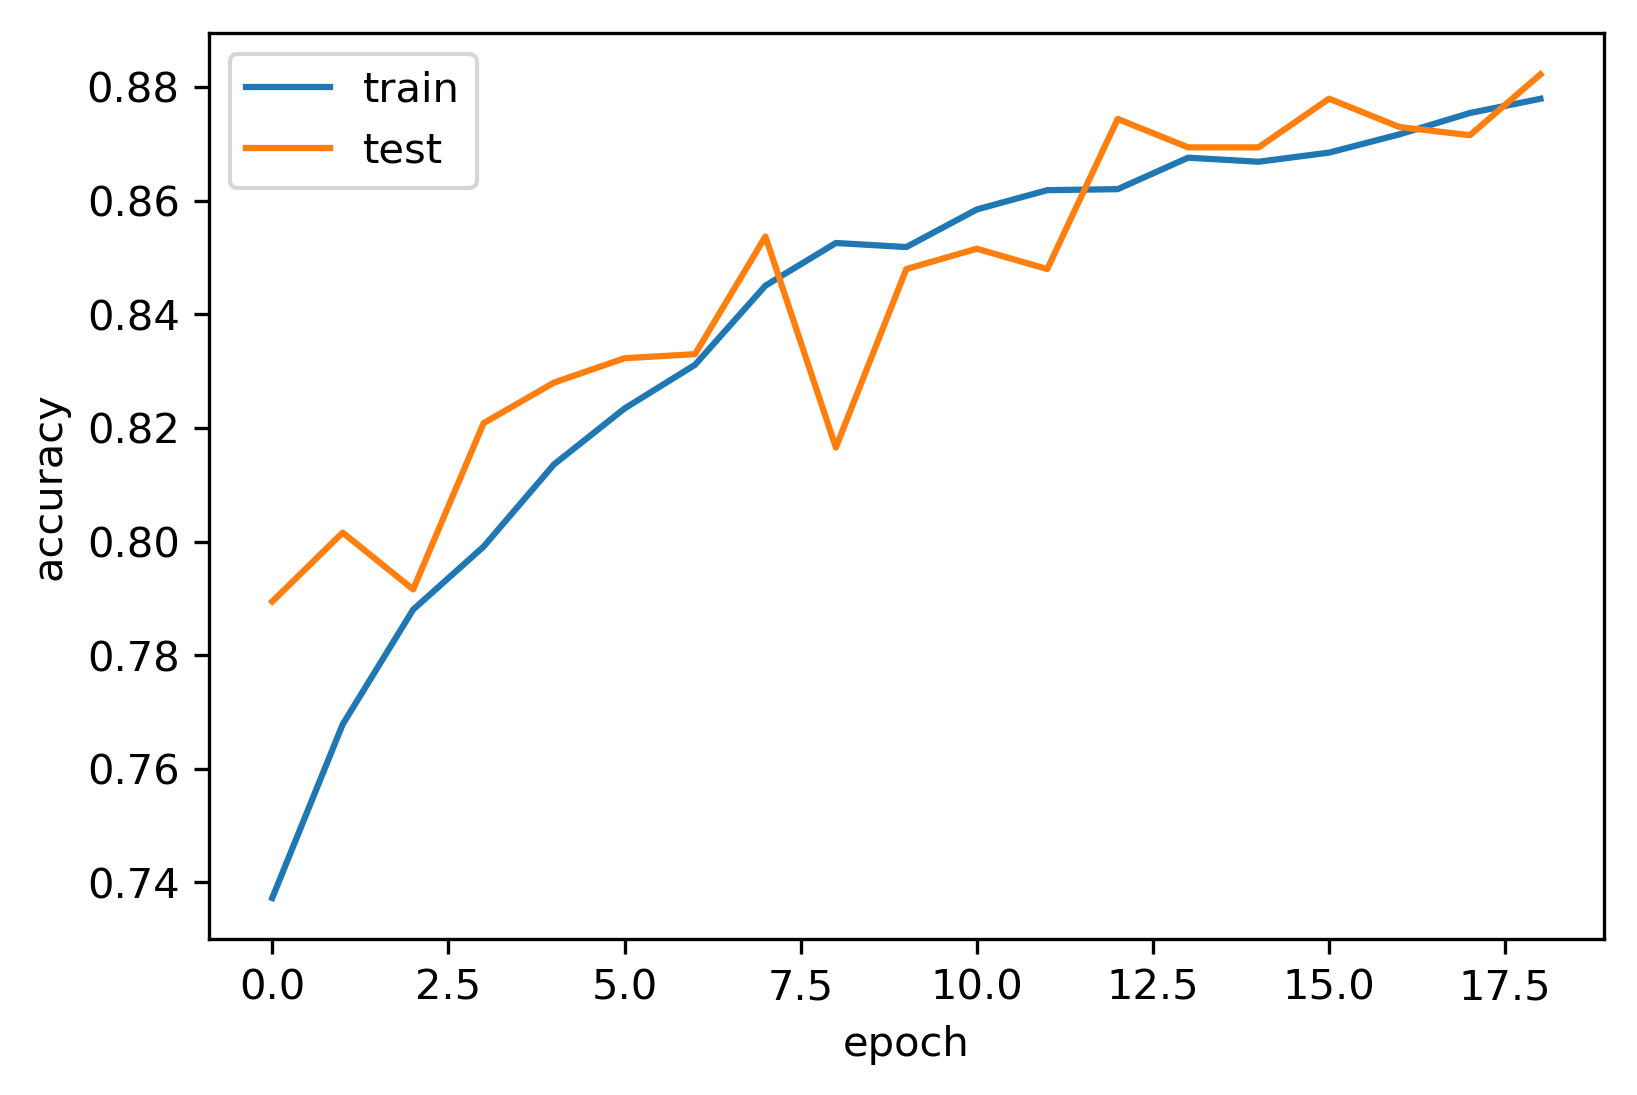

Test convolutional network with parameters {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]}:
Trained for 26 epochs
loss: 0.3689, binary_accuracy: 0.8365, mean_squared_error: 0.1151, precision: 0.8447, recall: 0.3912, fmeasure: 0.5142
Trained for 23 epochs
loss: 0.3620, binary_accuracy: 0.8380, mean_squared_error: 0.1150, precision: 0.7797, recall: 0.3302, fmeasure: 0.4462
Trained for 50 epochs
loss: 0.3901, binary_accuracy: 0.8298, mean_squared_error: 0.1223, precision: 0.6693, recall: 0.4926, fmeasure: 0.5377
Trained for 28 epochs
loss: 0.3809, binary_accuracy: 0.8526, mean_squared_error: 0.1202, precision: 0.6744, recall: 0.6556, fmeasure: 0.6492
Trained for 18 epochs
loss: 0.4487, binary_accuracy: 0.7904, mean_squared_error: 0.1430, precision: 0.6915, recall: 0.2585, fmeasure: 0.3620
loss: 0.3901 (+/-0.0309), binary_accuracy: 0.8295 (+/-0.0209), mean_squared_error: 0.1231 (+/-0.0103), precision: 0.7319 (+/-0.0691), recall: 0.4256 (+/-0.1383), fmeasure: 0.5019 (+/-0.0957)


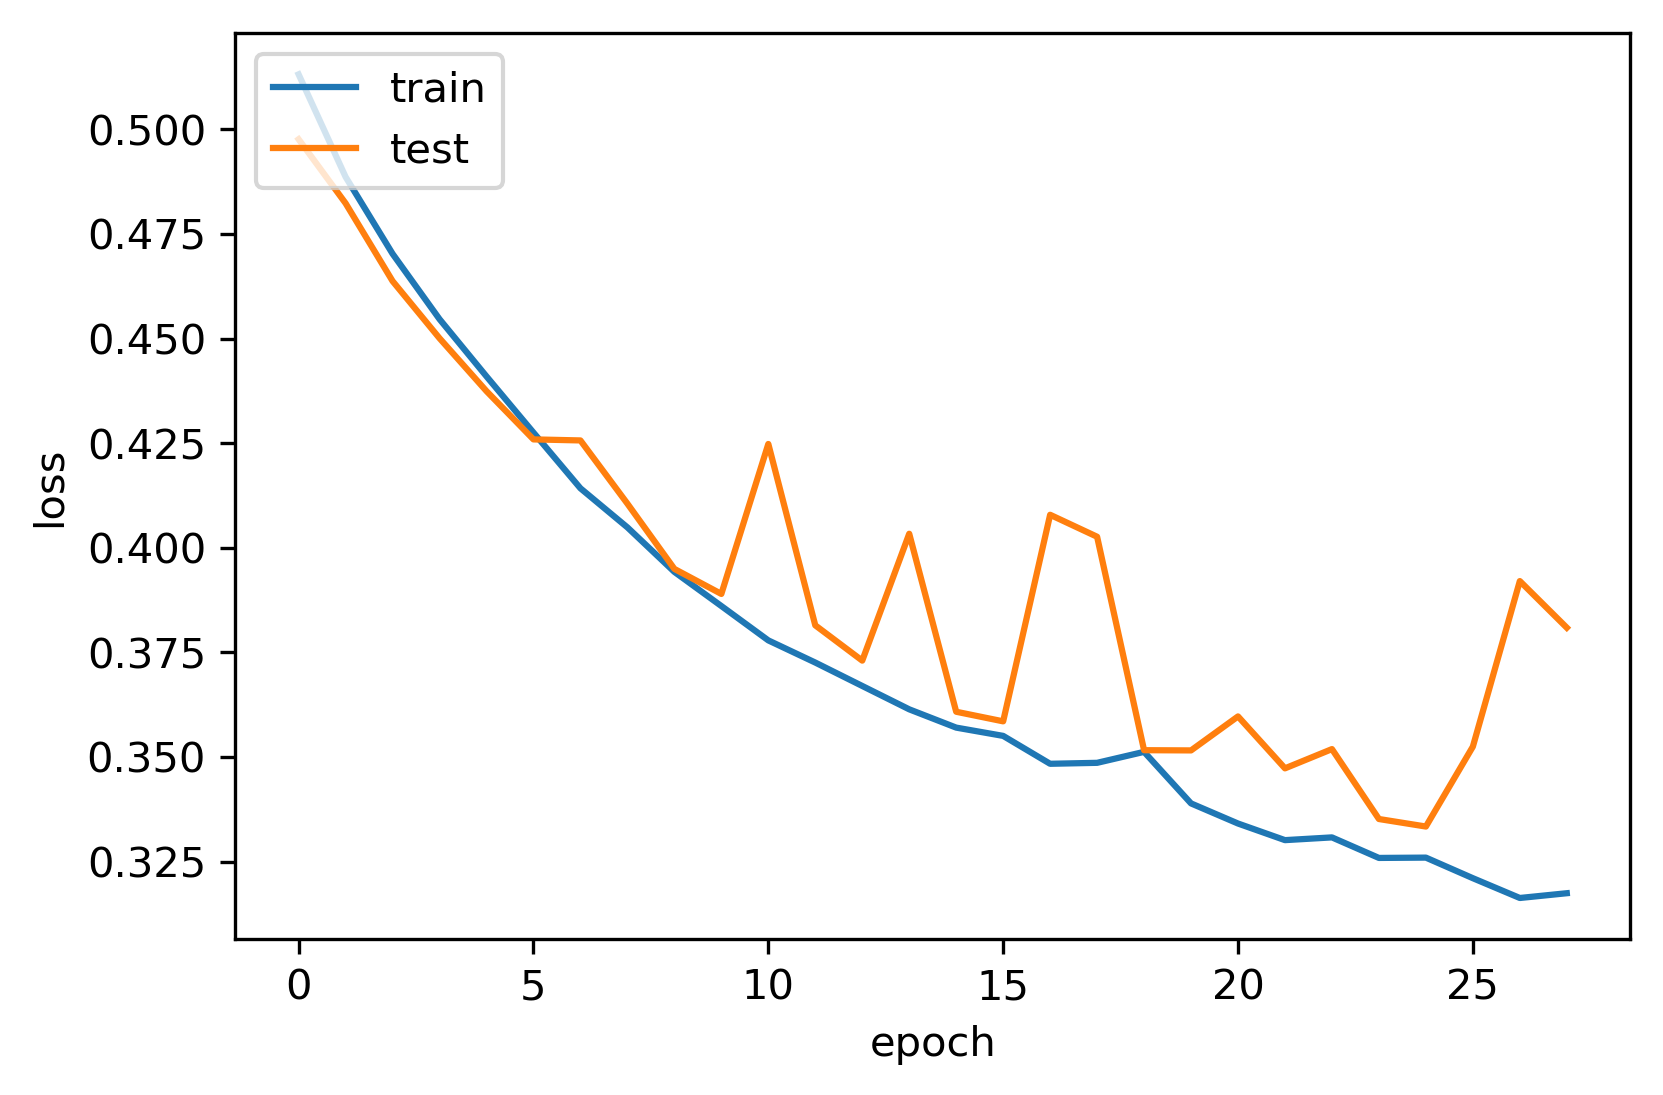

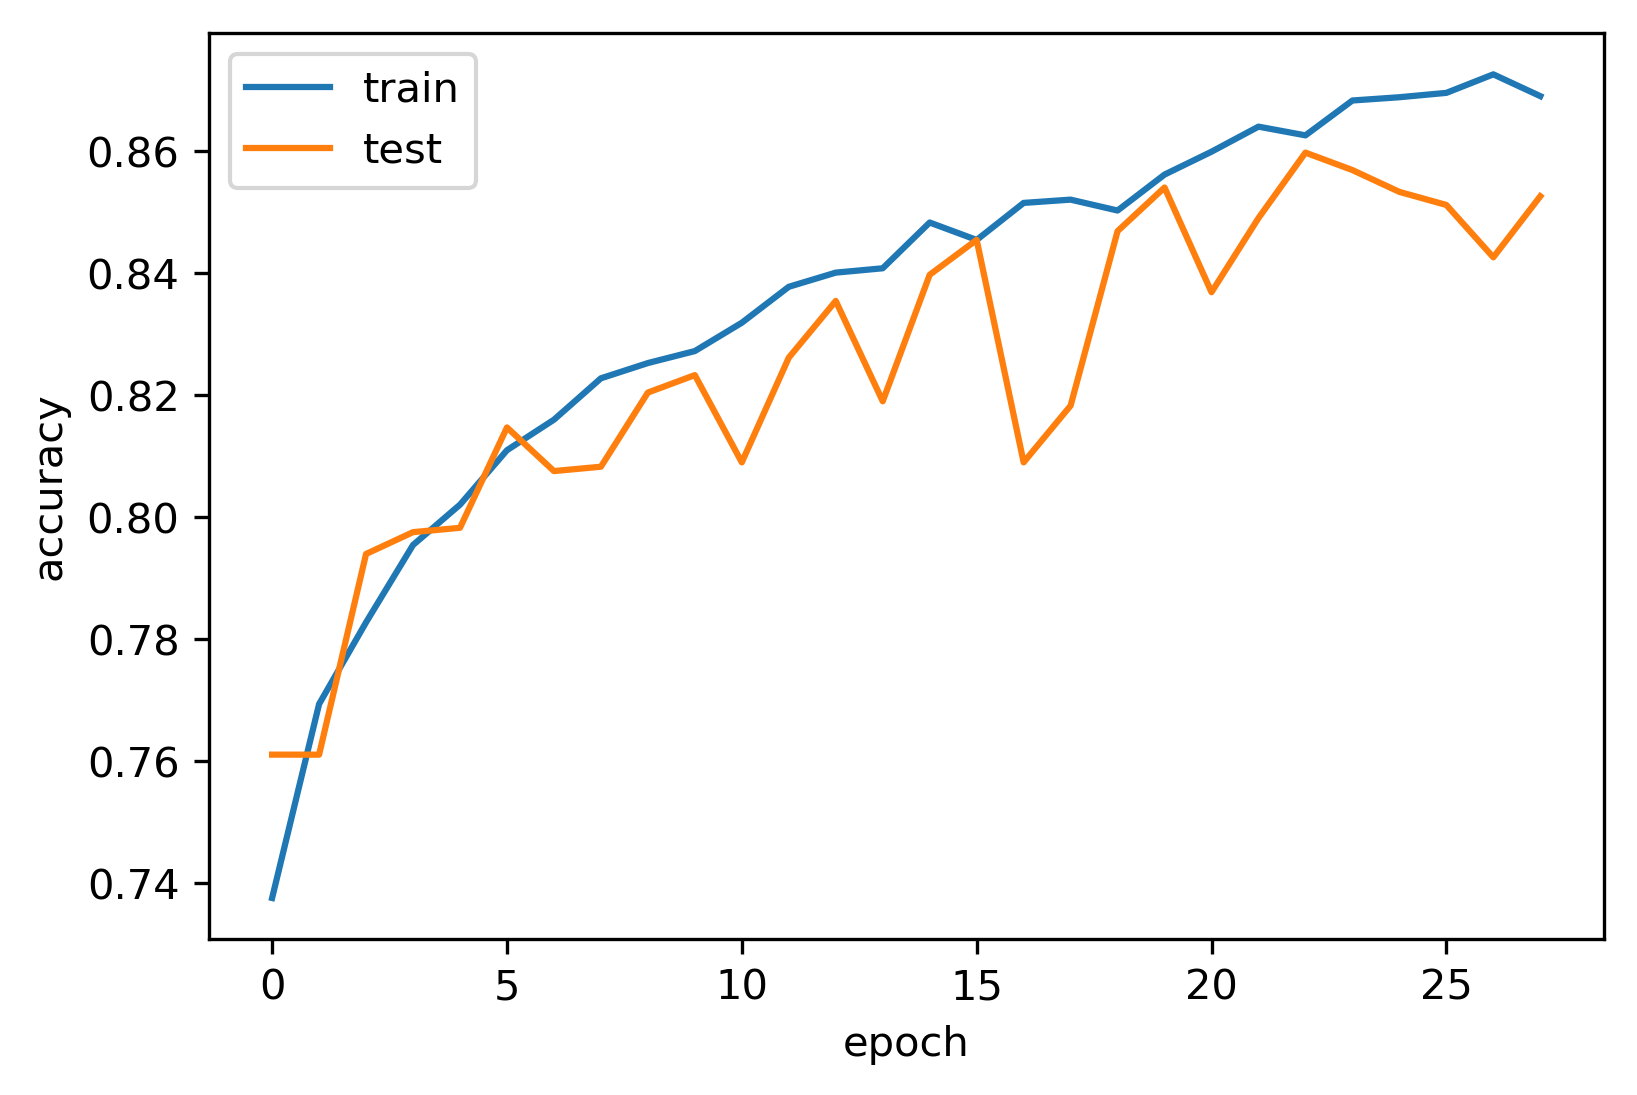

In [9]:
considered_variants = [
    {'pool': 16, 'layers': [(4, 16), (16, 16)]},
    {'pool': 16, 'layers': [(32, 16), (16, 16)]},
    {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]},
]

for i, variant in enumerate(considered_variants):
    print("Test convolutional network with parameters {}:".format(variant))
    filename = network_name('conv_' + str(i))
    trained = tester.test_model(conv_network(**variant), max_epochs=50)
    trained.save(filename)